In [1]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F

import os
from collections import OrderedDict
import math
import tqdm
import numpy as np
from matplotlib import pyplot as plt
import wandb

import nlp
from transformers import BertForMaskedLM, BertTokenizer, RobertaForMaskedLM, RobertaTokenizer

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /home/teven/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    print("Using CUDA!")
    torch_t = torch.cuda
    def from_numpy(ndarray):
        return torch.from_numpy(ndarray).pin_memory().cuda(async=True)
else:
    print("Not using CUDA!")
    torch_t = torch
    from torch import from_numpy
    
def torch_load(load_path):
    if use_cuda:
        return torch.load(load_path)
    else:
        return torch.load(load_path, map_location = 
                          lambda storage, location: storage)

Using CUDA!


In [3]:
class SentenceOrWordBert(nn.Module):
    def __init__(self, model_type, model_name):
        super().__init__()
        MODEL_CLASSES = {
            'bert': (BertForMaskedLM, BertTokenizer),
            'roberta': (RobertaForMaskedLM, RobertaTokenizer),
        }
        model_class, tokenizer_class = MODEL_CLASSES[model_type]
        self.tokenizer = tokenizer_class.from_pretrained(model_name, do_lower_case=('uncased' in model_name))
        self.bert_lm = model_class.from_pretrained(model_name)
        self.bert = self.bert_lm.bert
        self.model_type = model_type

        self.dim = self.bert.pooler.dense.in_features
        self.max_len = self.bert.embeddings.position_embeddings.num_embeddings
        
        self.unmasked_label_id = -100
        
        if use_cuda:
            self.cuda()
    
    def tokenize(self, sent, label_mask, include_clssep = False):
        """
        sent - string or list of words
        label_mask - list of either 0 or 1, 1 for masked (same length as sent)
        include_clssep - whether or not to include [CLS] and [SEP] in end_mask
        
        input_ids - sent converted to ids, with some ids masked
        end_mask - each word might be multiple subwords, so end_mask is 1 for
            the final subword of each word
        label_ids - -100 for unmasked tokens, the label for masked tokens
        """
        if isinstance(sent, str):
            sent = word_tokenize(sent)
        if label_mask is None:
            label_mask = [0 for _ in sent]
        
        input_ids = [self.tokenizer.cls_token_id]
        end_mask = [int(include_clssep)]
        label_ids = [self.unmasked_label_id]
        for word, is_masked in zip(sent, label_mask):
            ids = self.tokenizer.encode(word, add_special_tokens = False)
            assert len(ids) > 0, "Unknown word {} in {}".format(word, sent)
            if is_masked:
                input_ids.extend([self.tokenizer.mask_token_id for _ in ids])
                label_ids.extend(ids)
            else:
                input_ids.extend(ids)
                label_ids.extend([self.unmasked_label_id for _ in ids])
            end_mask.extend([0 for _ in ids])
            end_mask[-1] = 1
        input_ids.append(self.tokenizer.sep_token_id)
        end_mask.append(int(include_clssep))
        label_ids.append(self.unmasked_label_id)
        return input_ids, end_mask, label_ids
    
    def tokenize_sentences(self, sentences, include_clssep = False, label_masks = None):
        """
        sentences - list of sentences, or tuples containing 2 sentences each
            each sentence is either a string a list of words
        """
        paired = isinstance(sentences[0], tuple) and len(sentences[0]) == 2
        if label_masks is None:
            if paired:
                label_masks = [(None, None) for _ in sentences]
            else:
                label_masks = [None for _ in sentences]
            
        all_input_ids = np.zeros((len(sentences), self.max_len), dtype = int) + self.tokenizer.pad_token_id
        all_input_mask = np.zeros((len(sentences), self.max_len), dtype = int)
        all_end_mask = np.zeros((len(sentences), self.max_len), dtype = int)
        all_label_ids = np.zeros((len(sentences), self.max_len), dtype = int) + self.unmasked_label_id
        
        max_sent = 0
        for s_num, (sent, label_mask) in enumerate(zip(sentences, label_masks)):
            if paired:
                input_ids1, end_mask1, label_ids1 = self.tokenize(sent[0], label_mask[0], include_clssep = include_clssep)
                input_ids2, end_mask2, label_ids2 = self.tokenize(sent[1], label_mask[1], include_clssep = include_clssep)
    
                input_ids = input_ids1 + input_ids2[1:] # [cls] sent1 [sep] sent2 [sep]
                end_mask = end_mask1 + end_mask2[1:]
                label_ids = label_ids1 + label_ids2[1:]
            else:
                input_ids, end_mask, label_ids = self.tokenize(
                    sent, label_mask, include_clssep = include_clssep)

            all_input_ids[s_num, :len(input_ids)] = input_ids
            all_input_mask[s_num, :len(input_ids)] = 1
            all_end_mask[s_num, :len(input_ids)] = end_mask
            all_label_ids[s_num, :len(input_ids)] = label_ids
            max_sent = max(max_sent, len(input_ids))
            
        all_input_ids = from_numpy(np.ascontiguousarray(all_input_ids[:, :max_sent]))
        all_input_mask = from_numpy(np.ascontiguousarray(all_input_mask[:, :max_sent]))
        all_end_mask = from_numpy(np.ascontiguousarray(all_end_mask[:, :max_sent])).to(torch.uint8)
        all_label_ids = from_numpy(np.ascontiguousarray(all_label_ids[:, :max_sent]))
        return all_input_ids, all_input_mask, all_end_mask, all_label_ids

    def run_bert(self, all_input_ids, all_input_mask, subbatch_size = 64):
        """
        all_input_ids, all_input_mask - tensors (batch, maxlen)
        features_all - tensor (batch, maxlen, dim)
        hidden_all - tuple of tensors (batch, maxlen, dim), one for embedding and one for each layer
        attentions_all - tuple of tensors (batch, heads, maxlen, maxlen), one for each layer
        """
        features_all = None
        attentions_all = None
        for i in range(0, len(all_input_ids), subbatch_size):
            input_ids = all_input_ids[i:i+subbatch_size]
            input_mask = all_input_mask[i:i+subbatch_size]
            
            # (batch, len, dim or vocab_size), tuple((batch, heads, len, len) x layers)
            features, _, attentions = self.bert(input_ids, attention_mask = input_mask, output_attentions = True)
                
            if features_all is None:
                features_all = features
                attentions_all = list(attentions)
            else:
                features_all = torch.cat((features_all, features), dim = 0)
                for i, (attn_all, attn) in enumerate(zip(attentions_all, attentions)):
                    attentions_all[i] = torch.cat((attn_all, attn), dim = 0)
        return features_all, attentions_all

    def annotate(self, sentences, include_clssep = False, word_level = False, subbatch_size = 64):
        """
        Input: list of sentences or sentence pairs
            include_clssep - whether or not to include [CLS] and [SEP] in the end_mask
        Output: tensor (len(sentences), bert_dim) with sentence representations, or
            tensor (num_words_packed, bert_dim) with word representations
        """
        all_input_ids, all_input_mask, all_end_mask, _ = \
            self.tokenize_sentences(sentences, include_clssep = include_clssep)
        features, attn = self.run_bert(all_input_ids, all_input_mask, subbatch_size = subbatch_size)
        if word_level:
            features = features.masked_select(all_end_mask.unsqueeze(-1)).reshape(-1, features.shape[-1])
        else:
            features = features[:,0]
        return features, all_input_ids, attn
    
    def run_bert_lm(self, all_input_ids, all_input_mask, all_label_ids, subbatch_size = 64):
        """
        all_input_ids, all_input_mask, all_label_ids - tensors (batch, maxlen)
        loss - 0-dim tensor
        logits_all - tensor (num_masked, vocabsize)
        hidden_all - tuple of tensors (batch, maxlen, dim), one for embedding and one for each layer
        attentions_all - tuple of tensors (batch, heads, maxlen, maxlen), one for each layer
        """        
        loss_sum, n = None, 0
        logits_all = None
        attentions_all = None
        for i in range(0, len(all_input_ids), subbatch_size):
            input_ids = all_input_ids[i:i+subbatch_size]
            input_mask = all_input_mask[i:i+subbatch_size]
            label_ids = all_label_ids[i:i+subbatch_size]

            loss, logits, attentions = self.bert_lm(input_ids, attention_mask = input_mask, labels = label_ids, output_attentions = True)
            logits = logits.masked_select((label_ids != -100).unsqueeze(-1)).reshape(-1, logits.shape[-1])
            
            if loss_sum is None:
                loss_sum, n = loss, 1
                logits_all = logits
                attentions_all = list(attentions)
            else:
                loss_sum, n = loss_sum + loss, n + 1
                logits_all = torch.cat((logits_all, logits), dim = 0)
                for i, (attn_all, attn) in enumerate(zip(attentions_all, attentions)):
                    attentions_all[i] = torch.cat((attn_all, attn), dim = 0)
        return loss_sum / n, logits_all, attentions_all
    
    def predict_mlm(self, sentences, label_masks, output_hidden = False, subbatch_size = 64):
        """
        Input: list of sentences, which are lists of words.
            list of masks, which are lists of either 0 or 1, 1 for masked
        Output: tensor (num_masked, vocab_size) with prediction logits
        """
        all_input_ids, all_input_mask, _, all_label_ids = self.tokenize_sentences(sentences, label_masks = label_masks)
        _, logits_all, attn = self.run_bert_lm(all_input_ids, all_input_mask, all_label_ids, subbatch_size = subbatch_size)
        return logits_all, all_input_ids, attn

    def reset_weights(self, encoder_only = True):
        for name, module in self.named_modules():
            if hasattr(module, 'reset_parameters') and ('encoder' in name or not encoder_only):
                module.reset_parameters()

In [4]:
class MLPClassifier(nn.Module):
    def __init__(self, bert, num_classes):
        super().__init__()
        self.bert = bert
        self.dropout = nn.Dropout(p = 0.1)
        self.span_tip = nn.Linear(self.bert.dim, num_classes)
        
        if use_cuda:
            self.cuda()

    def forward(self, sentences, word_level = False):
        embs, _, _ = self.bert.annotate(sentences, word_level = word_level)
        return self.span_tip(self.dropout(embs))
    
    def freeze_head(self, freeze = True):
        for param in self.span_tip.parameters():
            param.requires_grad = not freeze
    
class MLMClassifier(nn.Module):
    def __init__(self, bert, classes): # ex: [['he', 'him', 'himself'], ['she', 'her', 'herself']]
        super().__init__()
        self.bert = bert
        self.classes = classes
        self.class_ids = []
        for lst in classes:
            ids = [self.bert.tokenizer.convert_tokens_to_ids(word) for word in lst]
            assert self.bert.tokenizer.unk_token_id not in ids
            self.class_ids.append(ids)
        
        if use_cuda:
            self.cuda()
            
    def forward(self, exmps): 
        # sentences are lists of words, label_masks are lists of 0/1 where 1 = masked
        sentences, label_masks = [e[0] for e in exmps], [e[1] for e in exmps]
        if isinstance(label_masks[0], tuple):
            assert all([sum(mask1 + mask2) == 1 for mask1, mask2 in label_masks]),  "There should be one masked word per sentence pair"
        else:
            assert all([sum(mask) == 1 for mask in label_masks]), "There should be one masked word per sentence"
        output_logits, _, _ = self.bert.predict_mlm(sentences, label_masks)
        assert len(output_logits) == len(sentences), \
            "Masked words should be one subword, but num_masks {} =/= num_sent {}".format(len(output_logits), len(sentences))
        output_logits = F.log_softmax(output_logits, dim = -1)
        class_logits = torch.cat(tuple(torch.logsumexp(output_logits[:, ids], dim = -1).unsqueeze(-1) for ids in self.class_ids), dim = -1)
        return class_logits

In [5]:
def calc_dev(model, dev_data, subbatch_size = 128): 
    model.eval()
    with torch.no_grad():
        preds = None
        for j in range(0, len(dev_data), subbatch_size):
            examples = dev_data[j:j+subbatch_size]
            logits = model([exmp[0] for exmp in examples])
            preds_batch = np.argmax(logits.cpu().numpy(), axis = 1)
            if preds is None:
                preds = preds_batch
            else:
                preds = np.concatenate((preds, preds_batch), axis = 0)
        dev_acc = np.sum(np.array([exmp[1] for exmp in dev_data]) == preds) / len(dev_data)
    return dev_acc

def train(model, train_data, dev_data, lr_base = 3e-5, lr_warmup_frac = 0.1,
          epochs = 5, batch_size = 32, subbatch_size = 8, verbose = True):
    print("lr_base: {}, lr_warmup_frac: {}, epochs: {}, batch_size: {}, len(train_data): {}".format(
        lr_base, lr_warmup_frac, epochs, batch_size, len(train_data)))

    bert_params = [p for n, p in model.named_parameters() if 'mask_score' not in n and p.requires_grad]
    trainer = torch.optim.Adam([
        {'params': bert_params, 'lr': 0., 'lr_base': lr_base, 'name': 'bert'},], lr = 0.)
    
    def set_lr(lr_ratio):
        for param_group in trainer.param_groups:
            param_group['lr'] = param_group['lr_base'] * lr_ratio

    log = []
    processed = 0
    check_processed = 0
    check_every = 2048
    train_acc_sum, train_acc_n = 0, 0
    for epoch in tqdm.notebook.tqdm(range(epochs)):
        np.random.shuffle(train_data)
        for i in tqdm.notebook.tqdm(range(0, len(train_data), batch_size)):
            examples = train_data[i:i+batch_size]
            if len(examples) == batch_size:
                model.train()
                trainer.zero_grad()

                for j in range(0, len(examples), subbatch_size):
                    examples_subbatch = examples[j:j+subbatch_size]

                    # compute loss, also log other metrics
                    logits = model([exmp[0] for exmp in examples_subbatch])
                    labels = np.array([exmp[1] for exmp in examples_subbatch])
                    loss = F.cross_entropy(logits, from_numpy(labels))
                    loss.backward()
                    bert_grad_norm = torch.nn.utils.clip_grad_norm_(bert_params, np.inf).item()
                    loss_val = loss.item()
                    del loss

                    batch_acc = np.sum(labels == np.argmax(logits.detach().cpu().numpy(), axis = 1)) / len(labels)
                    train_acc_sum += batch_acc
                    train_acc_n += 1

                trainer.step()
                processed += len(examples)
                check_processed += len(examples)

                # warmup from 0 to lr_base for lr_warmup_frac
                lr_ratio = min(1, processed / (lr_warmup_frac * epochs * len(train_data)))
                set_lr(lr_ratio)

                if check_processed >= check_every:
                    log.append({'dev_acc': calc_dev(model, dev_data), 
                                'train_acc': train_acc_sum / train_acc_n, 
                                'loss_val': loss_val,
                                'bert_grad_norm': bert_grad_norm})
                    train_acc_sum, train_acc_n = 0, 0
                    check_processed -= check_every
                    if verbose:
                        print("Epoch: {}, Log: {}".format(epoch, log[-1]))
    return log

In [6]:
def setup_dataset(dataset, num_labels, num_examples, dataset_name):
    np.random.seed(0)
    idx = np.arange(len(dataset))
    np.random.shuffle(idx)
    
    if dataset_name == 'mnli':
        num_per_label = num_examples // num_labels
        current_num_per_label = [0 for _ in range(num_labels)]
        examples = []
        for i in idx:
            exmp = dataset[int(i)]
            if all([num == num_per_label for num in current_num_per_label]):
                break
            if current_num_per_label[exmp['label']] < num_per_label:
                current_num_per_label[exmp['label']] += 1
                examples.append(((exmp['hypothesis'], exmp['premise']), exmp['label']))
    elif dataset_name in ('cola', 'sst2'):
        num_per_label = num_examples // num_labels
        current_num_per_label = [0 for _ in range(num_labels)]
        examples = []
        for i in idx:
            exmp = dataset[int(i)]
            if all([num == num_per_label for num in current_num_per_label]):
                break
            if current_num_per_label[exmp['label']] < num_per_label:
                current_num_per_label[exmp['label']] += 1
                examples.append((exmp['sentence'], exmp['label']))
    else:
        assert False, "Not implemented for dataset {}".format(dataset_name) 
    return examples

def convert_to_mlm(examples):
    classes = [['yes', 'right'], ['maybe'], ['wrong', 'no']]
    mlm_examples = []
    for (hyp, premise), label in examples:
        hyp = word_tokenize(hyp)
        premise = [classes[label][0]] + [','] + word_tokenize(premise)
        mask1 = [0 for _ in hyp]
        mask2 = [0 for _ in premise]
        mask2[0] = 1
        mlm_examples.append((((hyp,premise), (mask1, mask2)), label))
    return mlm_examples, classes

In [7]:
do_mlm = False

dataset = nlp.load_dataset('glue', 'mnli')
num_labels = max([exmp['label'] for exmp in dataset['validation_matched']]) + 1
train_data = setup_dataset(dataset['train'], num_labels, 10000, 'mnli')
dev_data = setup_dataset(dataset['validation_matched'], num_labels, 512, 'mnli')

if do_mlm:
    train_data, classes = convert_to_mlm(train_data)
    dev_data, classes = convert_to_mlm(dev_data)

print(len(train_data), len(dev_data))
print(train_data[0], dev_data[0])

Dataset glue downloaded and prepared to /home/teven/.cache/huggingface/datasets/glue/mnli/1.0.0. Subsequent calls will reuse this data.
9999 510
(('Before we send this to federal court, there is a conference.', 'Before any legal action is brought against this rule in federal court, the administrative appeal rights set forth at 7 C.F.R.'), 2) (('The plants are strictly seasonal, only grown during the winter.', "oh really it wouldn't matter if we plant them when it was starting to get warmer"), 2)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMaskedLM were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['cls.predictions.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


lr_base: 3e-05, lr_warmup_frac: 0.1, epochs: 5, batch_size: 32, len(train_data): 9999


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of cuda is deprecated:
	cuda(torch.device device, bool async, *, torch.memory_format memory_format)
Consider using one of the following signatures instead:
	cuda(torch.device device, bool non_blocking, *, torch.memory_format memory_format)


Epoch: 0, Log: {'dev_acc': 0.3862745098039216, 'train_acc': 0.32470703125, 'loss_val': 1.1222738027572632, 'bert_grad_norm': 10.740423202514648}
Epoch: 0, Log: {'dev_acc': 0.4823529411764706, 'train_acc': 0.40185546875, 'loss_val': 1.1545213460922241, 'bert_grad_norm': 14.548316955566406}
Epoch: 0, Log: {'dev_acc': 0.5764705882352941, 'train_acc': 0.5517578125, 'loss_val': 1.0056507587432861, 'bert_grad_norm': 23.257835388183594}
Epoch: 0, Log: {'dev_acc': 0.6411764705882353, 'train_acc': 0.63818359375, 'loss_val': 0.8350276350975037, 'bert_grad_norm': 20.716341018676758}



Epoch: 1, Log: {'dev_acc': 0.6627450980392157, 'train_acc': 0.65771484375, 'loss_val': 0.34977081418037415, 'bert_grad_norm': 24.23662567138672}
Epoch: 1, Log: {'dev_acc': 0.6568627450980392, 'train_acc': 0.73876953125, 'loss_val': 0.4647424817085266, 'bert_grad_norm': 24.433307647705078}
Epoch: 1, Log: {'dev_acc': 0.6980392156862745, 'train_acc': 0.744140625, 'loss_val': 0.5301686525344849, 'bert_grad_norm': 28.185781478881836}
Epoch: 1, Log: {'dev_acc': 0.7333333333333333, 'train_acc': 0.74365234375, 'loss_val': 0.5681180953979492, 'bert_grad_norm': 29.611652374267578}
Epoch: 1, Log: {'dev_acc': 0.7509803921568627, 'train_acc': 0.74072265625, 'loss_val': 0.4650135636329651, 'bert_grad_norm': 27.86673355102539}



Epoch: 2, Log: {'dev_acc': 0.7235294117647059, 'train_acc': 0.79833984375, 'loss_val': 0.6873937845230103, 'bert_grad_norm': 68.83441925048828}
Epoch: 2, Log: {'dev_acc': 0.7254901960784313, 'train_acc': 0.890625, 'loss_val': 0.23387622833251953, 'bert_grad_norm': 30.663543701171875}
Epoch: 2, Log: {'dev_acc': 0.711764705882353, 'train_acc': 0.880859375, 'loss_val': 0.6374986171722412, 'bert_grad_norm': 35.54377365112305}
Epoch: 2, Log: {'dev_acc': 0.7137254901960784, 'train_acc': 0.876953125, 'loss_val': 1.16610848903656, 'bert_grad_norm': 48.4563102722168}
Epoch: 2, Log: {'dev_acc': 0.7352941176470589, 'train_acc': 0.87744140625, 'loss_val': 0.1731954663991928, 'bert_grad_norm': 38.25436019897461}



Epoch: 3, Log: {'dev_acc': 0.7235294117647059, 'train_acc': 0.90966796875, 'loss_val': 0.04037974774837494, 'bert_grad_norm': 20.24699592590332}
Epoch: 3, Log: {'dev_acc': 0.6901960784313725, 'train_acc': 0.96875, 'loss_val': 0.21081013977527618, 'bert_grad_norm': 50.49439239501953}
Epoch: 3, Log: {'dev_acc': 0.6980392156862745, 'train_acc': 0.94873046875, 'loss_val': 0.056136295199394226, 'bert_grad_norm': 30.07563591003418}
Epoch: 3, Log: {'dev_acc': 0.7137254901960784, 'train_acc': 0.95361328125, 'loss_val': 0.46837031841278076, 'bert_grad_norm': 29.75871467590332}
Epoch: 3, Log: {'dev_acc': 0.692156862745098, 'train_acc': 0.9541015625, 'loss_val': 0.3137102425098419, 'bert_grad_norm': 74.92494201660156}



Epoch: 4, Log: {'dev_acc': 0.696078431372549, 'train_acc': 0.96533203125, 'loss_val': 0.03477981686592102, 'bert_grad_norm': 13.86160945892334}
Epoch: 4, Log: {'dev_acc': 0.711764705882353, 'train_acc': 0.97021484375, 'loss_val': 0.11734185367822647, 'bert_grad_norm': 55.438079833984375}
Epoch: 4, Log: {'dev_acc': 0.7098039215686275, 'train_acc': 0.974609375, 'loss_val': 0.0022845864295959473, 'bert_grad_norm': 10.539341926574707}
Epoch: 4, Log: {'dev_acc': 0.7156862745098039, 'train_acc': 0.9765625, 'loss_val': 0.002421140670776367, 'bert_grad_norm': 42.88307189941406}
Epoch: 4, Log: {'dev_acc': 0.7137254901960784, 'train_acc': 0.96826171875, 'loss_val': 0.5883772373199463, 'bert_grad_norm': 34.58256149291992}


Final results: {'dev_acc': 0.7137254901960784, 'train_acc': 0.96826171875, 'loss_val': 0.5883772373199463, 'bert_grad_norm': 34.58256149291992}


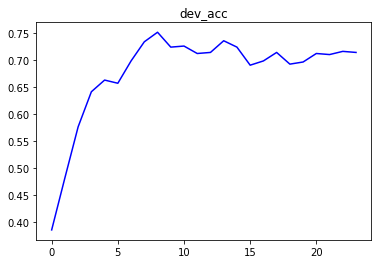

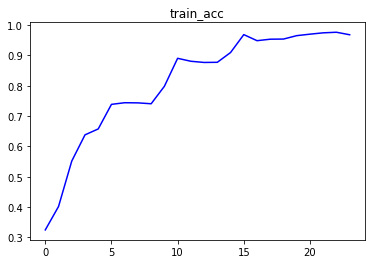

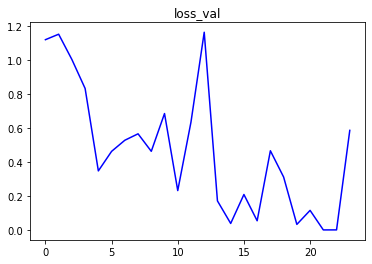

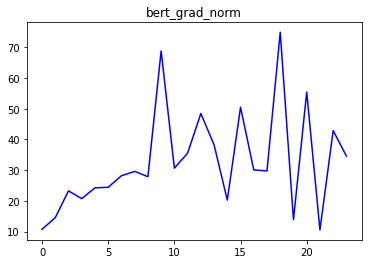

In [8]:
bert = SentenceOrWordBert('bert', 'bert-base-uncased')
if do_mlm:
    model = MLMClassifier(bert, classes)
else:
    model = MLPClassifier(bert, num_labels)

log = train(model, train_data, dev_data, verbose = True, epochs = 5)
print("Final results: {}".format(log[-1]))
for key in log[0].keys():
    plt.plot(np.arange(len(log)), [a[key] for a in log], color='blue')
    plt.title(key)
    plt.show()